In [1]:
import grasp2alm as g2a
import numpy as np
import healpy as hp
import math
import os
import matplotlib.pyplot as plt
from math import factorial

In [2]:
pol = True
nside: int = 1024
lmax: int = 2*nside
beam_fwhm_deg = 0.5
beam_fwhm = np.deg2rad(beam_fwhm_deg)
beam_sigma = beam_fwhm/np.sqrt(8.0*np.log(2.0))
amplitude = 1/(2*np.pi*beam_sigma*beam_sigma)
bias = 0.0

In [3]:
beam_fwhm_deg

0.5

In [4]:
vini: float = -beam_fwhm_deg*2
vnum = 30001
vinc: float = abs(vini)*2/vnum
c = 0
ncut = 40
header_1: str = "Field data in cuts"
header_2 = f"{vini} {vinc} {vnum} {c} 3 1 2"

theta = np.linspace(vini, -vini, vnum)
theta = np.deg2rad(theta)

phi = np.linspace(0, 180-180/ncut, ncut)

The gaussian beam in $\theta,\phi$ coordinates is:
$$
B(\theta)=\frac{1}{2\pi\sigma^2}\exp{-\frac{\theta^2}{2\sigma^2}}
$$
alternatively, we can follow _Challinor et al_ by using:
$$
B(\theta)=\frac{1}{2\pi\sigma^2}\exp{-\frac{1-\cos(\theta)}{\sigma^2}}
$$

In [5]:
gauss = g2a.BeamGauss(amplitude, beam_fwhm_deg)
gauss.write2cut('prova.cut', vini, vnum, ncut)

In [6]:
if os.path.exists('prova.cut'):
    cut = g2a.BeamCut('prova.cut')
    os.remove('prova.cut')

In [7]:
outOftheta_val = hp.UNSEEN
cpolar = cut.to_polar(copol_axis="y")

In [8]:
#prova = gauss.write2thetaphigrid("test.grd", 0.0, 0.0, 360, 90, 61, 30000)
#grid = g2a.BeamGrid("test.grd")
#grid = grid.to_polar(copol_axis = "y")
#grid = grid.to_map(nside, outOftheta_val=outOftheta_val, interp_method='linear')
#hp.gnomview(grid.map[0], rot=[0,90])

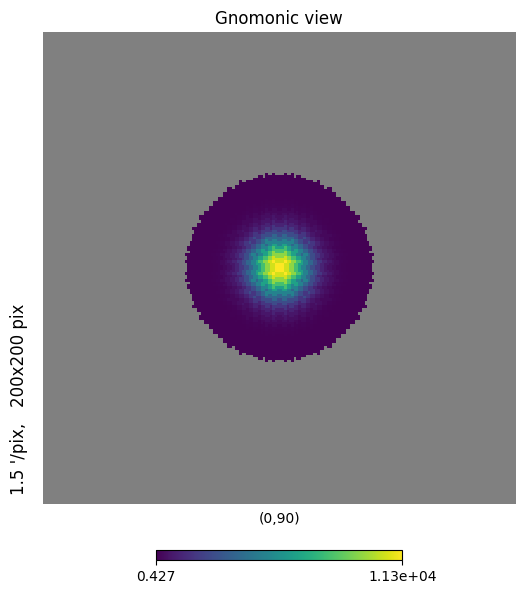

In [9]:
cmap = cpolar.to_map(nside, outOftheta_val=outOftheta_val, interp_method='pchip')
hp.gnomview(cmap.map[0], rot=[0,90])

In [10]:
# Rotate the beam into x-direction
#rot_matrix = (0,-90,0)
#r = hp.Rotator(rot=rot_matrix, inv=True, deg=True)
#cmap.map = np.array(r.rotate_map_alms(cmap.map))
#hp.gnomview(cmap.map[0])

In [11]:
calm = cmap.to_alm(lmax=lmax, use_pixel_weights=False)

In [12]:
#r_alm = r.get_inverse()
#calm = r_alm.rotate_alm(calm, lmax=lmax)

# Compare against theoric

Following LevelS convention:
$$
a_{lm}^T=\sqrt\frac{2l+1}{4\pi}\exp{(-\frac{\sigma^2}{2}l^2)} \\
a_{lm}^E=-\sqrt{2}\sqrt\frac{2l+1}{32\pi}\exp{(-\frac{\sigma^2}{2}l^2)} \\
a_{lm}^B=i*a_{lm}^E
$$

*Two problems:*
- The $\sqrt{2}$ is absent into healpy convention
- The $l^2$ inside the exponential doesn't work well, instead we decided to use $l(l+1)$

See the following issue: https://github.com/healpy/healpy/issues/861

In [13]:
#blm=hp.blm_gauss(beam_fwhm, lmax=lmax, pol=pol)
blm=gauss.get_alm(lmax=lmax, mmax=2, pol=pol)

In [14]:
index_0 = hp.Alm.getidx(lmax, np.arange(lmax), 0)
index_2 = hp.Alm.getidx(lmax, np.arange(lmax), 2)
indexes = [index_0, index_2, index_2]

In [15]:
alm_T_0_yusuke = calm[0][index_0]
alm_E_2_yusuke = calm[1][index_2]
alm_B_2_yusuke = calm[2][index_2]
alm_yusuke = np.array([alm_T_0_yusuke, alm_E_2_yusuke, alm_B_2_yusuke])

alm_T_0_hp = blm[0][index_0]
alm_E_2_hp = blm[1][index_2]
alm_B_2_hp = blm[2][index_2]
alm_hp = np.array([alm_T_0_hp, alm_E_2_hp, alm_B_2_hp])

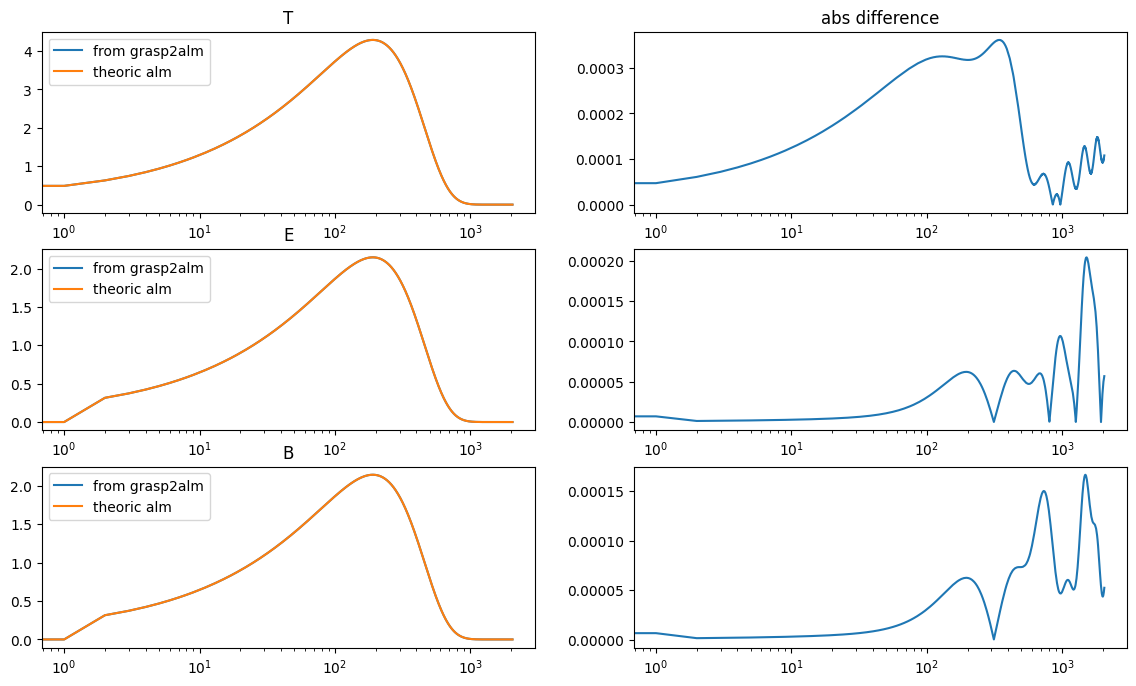

In [16]:
fig, axs = plt.subplots(3,2, figsize=(14,8))
for indx, stokes in enumerate('TEB'):
    axs[indx,0].plot(abs(alm_yusuke[indx]), label='from grasp2alm')
    axs[indx,0].plot(abs(alm_hp[indx]), label='theoric alm')
    axs[indx,0].set_title(stokes)
    axs[indx,0].legend()

    axs[0,1].set_title('abs difference')
    axs[indx,1].plot( abs(alm_yusuke[indx]-alm_hp[indx]) )

    axs[indx,0].set_xscale('log')
    axs[indx,1].set_xscale('log')

In [17]:
np.allclose(alm_yusuke[0], alm_hp[0], atol=1e-3)

True

In [18]:
np.allclose(alm_yusuke[1], alm_hp[1], atol=1e-3)

True

In [19]:
np.allclose(alm_yusuke[2], alm_hp[2], atol=1e-3)

True

# Check reconstructed maps

In [20]:
m_g2a = hp.alm2map(calm, lmax=lmax, nside=nside, pol=pol)
m_hp = hp.alm2map(blm, lmax=lmax, mmax=2, nside=nside, pol=pol)

map_diff = m_g2a - m_hp

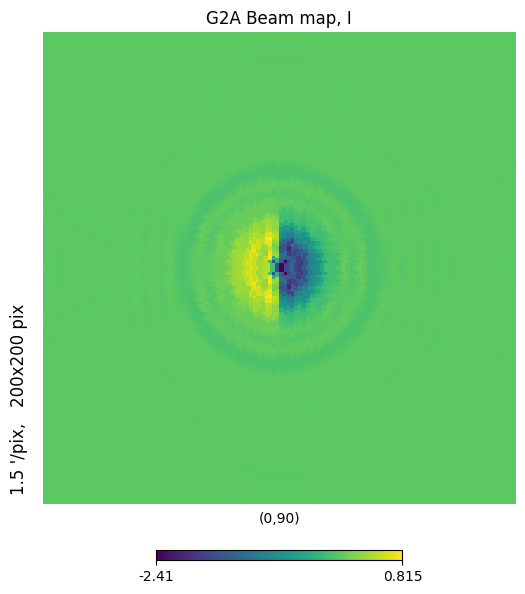

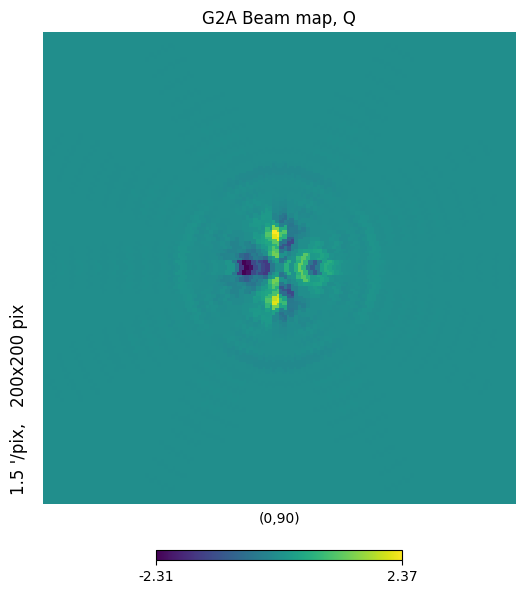

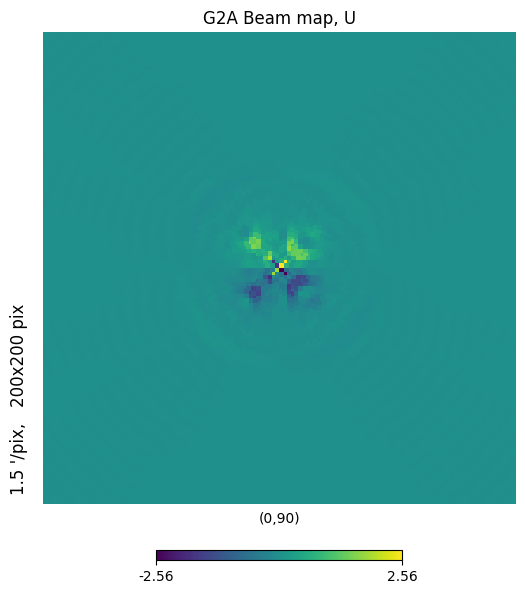

In [21]:
for each_m, label in zip(map_diff, "IQU"):
    hp.gnomview(each_m, rot=[0, 90], title=f"G2A Beam map, {label}")